# Image Classifier - MIDAS INTERNSHIP CHALLENGE

In [51]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Explanation - 1
The following code is used to import the our 3rd Party Deep Learning Libraries like *Pytorch* as well as checks, if the GPU is set or not.

<img src ="https://cdn-images-1.medium.com/max/2600/1*aqNgmfyBIStLrf9k7d9cng.jpeg"/>

In [52]:
from fastai.vision import *
from fastai.metrics import error_rate
from lr_finder import LRFinder
import pandas as pd
import time
from torch.utils.data.sampler import SubsetRandomSampler
import os
from torch.autograd import Variable
import matplotlib.image as mpimg
from PIL import Image
import torch
import copy
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn, optim
import torch.optim as optim
import numpy as np
import torch
import pickle
import os
import torchvision
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Device is usage: {0}".format(device))

Device is usage: cuda:0


## Explanation 2

### Intuition
The code block below defines few global variables that we would like to take care of, for example the batch size for our Deep Learning Pipeline as well as the paths of the training data/labels as well as the test_data

In [53]:
data_path = "./data"
train_images_path = "{0}/train_image.pkl".format(data_path)
test_images_path = "{0}/test_image.pkl".format(data_path)
train_labels_path = "{0}/train_label.pkl".format(data_path)
sanitized_labels_path = "{0}/train_labels_sanitized.pkl".format(data_path)
batch_size = 64
random_seed = 43
validation_split = 0.2
shuffle_dataset = True
torch.manual_seed(random_seed)

In [54]:
def path_exists(path):
    """
     Function to verfiy if, file path defined is correct
    """
    return os.path.exists(path)

valid_path = [path_exists(_) for _ in (train_images_path, test_images_path, train_labels_path)]
valid_path

[True, True, True]

In [55]:
def sanitize_labels(labels_path):
    """
        The labels given in the file are 0, 2, 3, 6
        Each label should be mapped to required class, as 0 -> 0, 2 -> 2, 3 -> 2, 6 -> 3
    """
    mapping = {0: 0, 2: 1, 3: 2, 6: 3}
    with open(labels_path, 'rb') as file:
        data = pickle.load(file)
    result = [mapping[i] for i in data]
    return result

result = sanitize_labels(train_labels_path)

with open(sanitized_labels_path, "wb") as file:
    pickle.dump(result, file)

path_exists(sanitized_labels_path)

True

## Deep Learning Pipeline - Data Pre-processing

<img src="https://cdn-images-1.medium.com/max/1200/1*ZX05x1xYgaVoa4Vn2kKS9g.png" />

### What's happening ?
In the code block we have defined a basic class which takes care of our pre-processing pipeline.

#### Why did we **inherit** the `Dataset`  class ?
We are using PyTorch as our DeepLearning framework, PyTorch provides a very simple API to build the Deep Learnign PipeLine, we can do make our own pipeline by inheriting the **Dataset** class, which has internal methods to take of the things we need to take care of pre-processing.

Here in our case I have divided the pipelin in the following parts.
- Load data from pickle dump.
- Build an API to *clean the data*, or arrange the data in a format that PyTorch understands, this has been done by the `__getitem__()` function.
    - This functions iteratively returns a single dataset and the following label for our Neural Net to work on. 
- We also incorporate transformations in the class, which helps us normalising our data.
    - **Normalising** input data is important, as this helps *Gradient Descent* to run faster, which means we can use a higher learning rate for our Neural Network, this helps us the reacht the minima faster, the contour of the cost functions are symmetrical when data is normalised.


In [56]:
class DataSetLoader(Dataset):
    '''Dataset Loader'''
    def __init__(self, train_path, labels_path, transform=None, train=True, target_transform=None):
        """
        Args:
            train_path (string): Path to the training data file
            labels_path (string): Path to the labels present for the training data
            transform (callable): Optional transform to apply to sample
        """
        self.train=train
        if self.train:
            data = self._load_from_pickle(train_path)
            self.train_data = torch.ByteTensor(data).view(-1, 28, 28) 
            self.train_labels = self._load_from_pickle(labels_path)
        else:
            data = self._load_from_pickle(train_path)
            self.test_data = torch.ByteTensor(data).view(-1, 28, 28) 
            self.test_lables = []
            
        del data
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        """
         Returns the length of whole Dataset fed into the Neural Net.
        """
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)
    
    def __getitem__(self, index):
        """
         Returns a single training/test example after applying the required normalisation/transformations techniques.
         As well as the label.
         
         ret: (image, label)
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img, target
    
    def _load_from_pickle(self, file_path):
        """
         file_path: File path to load data, returns an ndarray
         
         ret: Loaded dump, in primitive data format.
        """
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
        return data
    
    def get_labels(self):
        """
         Return an array of labels present in the data set.
        """
        if self.train:
            return np.unique(self.train_labels)
        return []
    
    def visualise_data_set(self):
        """
         Utility function to randomly display images from the dataset
        """
        fig = plt.figure(figsize=(8,8))
        columns = 4
        rows = 5
        if self.train:
            data_set = self.train_data
        else:
            data_set = self.test_data
        for i in range(1, columns * rows +1):
            img_xy = np.random.randint(len(data_set));
            img = data_set[img_xy][0][0,:,:]
            fig.add_subplot(rows, columns, i)
            plt.title(labels_map[data_set[img_xy][1]])
            plt.axis('off')
            plt.imshow(img)
        
        plt.show()            

In [57]:
# Creating a labels map for storing the labels


# Define the normalisation/tranformation techniques we need during pre-processing.
img_transforms = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [58]:
# Create training and test data sets.
train_dataset = DataSetLoader(train_images_path, sanitized_labels_path, train=True, transform=img_transforms)
test_dataset = DataSetLoader(test_images_path, "", train=False, transform=img_transforms)

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

## Looking at the data

The following code blocks gives us some insights about what kind of images our data set has.
By looking at the training set, we have 4 labels, *0, 2 ,3, 6*, these labels are numerically labelled in our training labelled data set.

Just for readibilty I have created a dictionary of mapping each numerical label to a physical label, like *Shirt*, *T-Shirt* etc.

```
labels = train_dataset.get_labels()
```
The code above gives us the unique labels present in our training data.
```
labels_map = {0 : 'T-Shirt', 2 : 'Pullover', 3 : 'Dress', 6 : 'Shirt'}
```
Initialises a dictionary to map each numerical label to a physical entity.

In [59]:
labels = train_dataset.get_labels()
labels_map = {0 : 'T-Shirt', 1 : 'Pullover', 2 : 'Dress', 3 : 'Shirt'}
for label in labels:
    print("Label: {0}, value: {1}".format(label, labels_map[label]))

Label: 0, value: T-Shirt
Label: 1, value: Pullover
Label: 2, value: Dress
Label: 3, value: Shirt


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


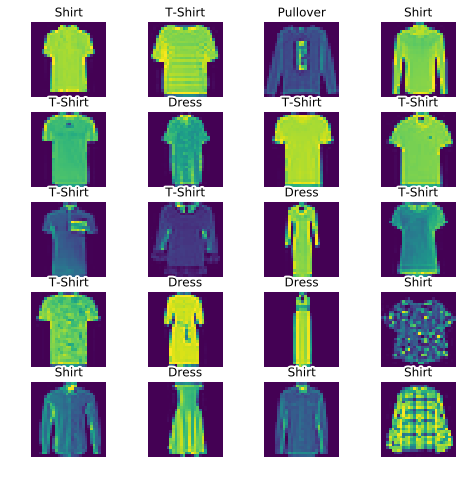

In [60]:
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img)
plt.show()


### Explanation of code block below

For our data pre-processing we have cleaned our data, applied required transformations, as well as wrote a simple API that allows us to do the steps gracefully.
What we need now is another API which can help us in iterating over our training/test datasets efficiently.

The following code does the same, **DataLoader** class provides us with an *Python* `iterator` object which allows for traverse over our dataset very efficiently, in specific batch size we want.

```
for i_batch, sample_batched in enumerate(trainloader):
    do_something(sample_batched)
```

Since trainloader is an iterator we can easily now iterate over our data set, you can also the see the code example above.

#### What's my intuition behind this ?

The most basic intuition in making an iterator here is we need to carry the basic Neural Net operations: 
  - Forward Propagation 
  - Backward Propagation

Since we want to carry out **Mini Batch Gradient Descent** for our Neural Network to learn the hyper-params, we are using this iterator to automatically create the required batches.

In [61]:
"""
    We built our data set using DataSetLoader class we defined above, now we need the the following operations
    1. Divide our dataset the into the batch sizes.
    2. Shuffle the dataset accordingly for randomness.
"""
trainloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)

validationloader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=2)

testloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=2)

## Model Creation

### What is code block doing ?
The code block below defines the architecture of a Convolutional Neural Network. Our input is an image of dimension, (28 x 28), usually images have 3 channels, **RED, BLUE AND GREEN**, but in the current data set we have only 1 channel, due to this we initialise our Convolutional Layer accordingly.

In the first Convolutional block of our CNN we use only a single channel that is 1, becaue input image has only 1 channel.
```
class CNN(nn.Module):
    def __init__(self):
     .....
     nn.Conv2d(1, 16, kernel_size=4, padding=2)
     .....
```

Similarly.

```
class CNN(nn.Module):

    def __init__(self):
        .....
        nn.Conv2d(16, 32, kernel_size=6, padding=2),
        ....
```
In the second Convolutional Block, the number of input channels are 16 as the number of channels that will be received from CNN block 1 are 16.

The code block above specifies that our Convolutional Blocks have a padding of 2 and kernel size of 5.

### My Intuition

The basic intuition behind the CNN architecture is to involve techniques like Batch Normalization and Regularisation techniques like Dropout, on one hand, as well know Gradient Descent will converge to a minima for the training set, 
but if the number of epochs are high, then this can lead to overfitting, therefore:
   - Dropout helps in regularising our weights to reduce overfitting, I have kept the probability of regularisation as 0.5
   - Batch Normalization smoothens the loss landscape and thus allows to converge faster to minima, using Gradient Descent.
   
As we will see the CNN architecture helps us to reduce overfitting and get the right balance of validation and training loss.

In [64]:
class CNN(nn.Module):
    """
        CNN architecture:
        CONV -> BatchNorm -> Relu -> MaxPool -> CONV -> BatchNorm -> Relu -> Dropout -> MaxPool -> Linear -> Output
    """
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=6, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=0.5),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 4)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [66]:
class ModelRunner:
    """
        Class to abstract how we train our model on training and validation data sets.
    """
    def __init__(self, learning_rate, epochs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.training_losses = []
        self.validation_losses = []
    
    def initialise_model(self):
        self.model = CNN().cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    def run_model(self):
        self.initialise_model()
        print("-------Running Model, with rate: {0} and epochs: {1} -------".format(self.learning_rate, self.epochs))
        for epoch in range(self.epochs):
            for i, (images, labels) in enumerate(trainloader):
                images = Variable(images.cuda().float())
                labels = Variable(labels.cuda())
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                self.training_losses.append(loss.data.item())
        
                if (i+1) % 100 == 0:
                    print('Epoch : %d/%d, Iter : %d/%d, Training Loss: %.4f' 
                       %(epoch+1, self.epochs, i+1, len(train_dataset)//batch_size, loss.data.item()))
        
        for i, (images, labels) in enumerate(validationloader):
            with torch.no_grad():
                images = Variable(images.cuda().float())
                labels = Variable(labels.cuda())
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                self.validation_losses.append(loss.data.item())
        self.plot_losses()
        print("\n \n")
        return self.model
    
    def plot_losses(self):
        plt.xkcd()
        plt.xlabel('Epoch #')
        plt.ylabel('Loss')
        plt.plot(self.training_losses[::100], label="Training loss")
        plt.legend()
        plt.title("Loss for rate: {0} and epochs: {1}".format(self.learning_rate, self.epochs))

-------Running Model, with rate: 0.001 and epochs: 10 -------
Epoch : 1/10, Iter : 100/125, Training Loss: 0.4919
Epoch : 2/10, Iter : 100/125, Training Loss: 0.5403
Epoch : 3/10, Iter : 100/125, Training Loss: 0.3268
Epoch : 4/10, Iter : 100/125, Training Loss: 0.3498
Epoch : 5/10, Iter : 100/125, Training Loss: 0.4287
Epoch : 6/10, Iter : 100/125, Training Loss: 0.3729
Epoch : 7/10, Iter : 100/125, Training Loss: 0.1661
Epoch : 8/10, Iter : 100/125, Training Loss: 0.1704
Epoch : 9/10, Iter : 100/125, Training Loss: 0.5317
Epoch : 10/10, Iter : 100/125, Training Loss: 0.3999

 

-------Running Model, with rate: 0.001 and epochs: 20 -------
Epoch : 1/20, Iter : 100/125, Training Loss: 0.6144
Epoch : 2/20, Iter : 100/125, Training Loss: 0.6584
Epoch : 3/20, Iter : 100/125, Training Loss: 0.5467
Epoch : 4/20, Iter : 100/125, Training Loss: 0.2899
Epoch : 5/20, Iter : 100/125, Training Loss: 0.1913
Epoch : 6/20, Iter : 100/125, Training Loss: 0.4728
Epoch : 7/20, Iter : 100/125, Training 

/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


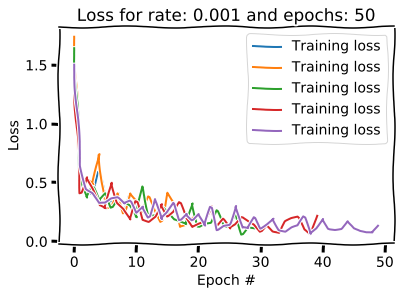

In [16]:
# Search over the hyper-params.
models = []
learning_rates = [0.001]
for rate in learning_rates:
    epochs = [10, 20, 30, 40, 50]
    for epoch in epochs:
        runner = ModelRunner(rate, epoch)
        models.append(runner.run_model())

In [35]:
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    for images, labels in validationloader:
        images, labels = images.to(device), labels.to(device)
        images = Variable(images.float())
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        print('Validation Accuracy of the model on validation images: %.4f %%' % (100 * correct / total))
        return (100 * correct / total)


In [47]:
def find_best_model(models):
    best_model = None
    best_metric = 0.0
    for model in models:
        metric = evaluate_model(model)
        if metric > best_metric:
            best_model = model
            best_metric = metric
    return best_model

In [48]:
best_model = find_best_model(models)

Validation Accuracy of the model on validation images: 82.0000 %
Validation Accuracy of the model on validation images: 89.0000 %
Validation Accuracy of the model on validation images: 75.0000 %
Validation Accuracy of the model on validation images: 84.0000 %
Validation Accuracy of the model on validation images: 81.0000 %


Validation Accuracy of the model on validation images: 93.0000 %


tensor(93, device='cuda:0')